### Loading packages

In [51]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties

# This will tell matplotlib that we want to include the plots on our notebook, rather than in a new window.
%matplotlib inline

# Here you can control the font for the plots.
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

# Set a random seed
np.random.seed(42)

In [52]:
### Models packages to be used

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import   GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

### Loading datasets
We had precipitation and rainfall data from 
-  [World Bank Climate Change Knowledge Portal](https://climateknowledgeportal.worldbank.org/)


In [53]:
### Loading the cleaned datasets
df_data = pd.read_csv("data/clean_data.csv")
# Remove specific columns using the drop method
df_data = df_data.drop('Unnamed: 0', axis=1)
df_data

,year,country,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,...,rural_population_percent_of_total_population_sp_rur_totl_zs,agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc
0,2010,Afghanistan,23.483,14.175,12084.400,0.534,-141355,43.220,NaN,-1.645,...,76.263,NaN,0.236,NaN,2.353,48.969,2.370,NaN,42.700,0.276
1,2010,Albania,112.025,12.208,7820.700,0.459,-29330,106.315,45.003,-0.532,...,47.837,NaN,1.235,4.018,11.615,20.979,2.390,NaN,99.644,0.215
2,2010,Algeria,7.700,23.708,19180.000,0.810,-33071,15.055,30.978,-0.552,...,32.460,NaN,NaN,NaN,4.831,27.571,2.260,NaN,98.911,0.209
3,2010,Andorra,72.592,8.258,160.000,0.176,-2864,152.168,NaN,1.302,...,11.181,NaN,NaN,NaN,10.826,16.319,NaN,NaN,100.000,0.011
4,2010,Antigua and Barbuda,240.083,26.958,87.800,0.378,295,194.761,16.603,1.302,...,73.762,NaN,NaN,NaN,7.100,23.779,NaN,NaN,98.691,0.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,2020,Uruguay,74.083,18.008,20310.000,0.115,-1486,19.593,64.933,1.365,...,4.485,NaN,NaN,NaN,15.338,19.797,NaN,NaN,100.000,0.590
1855,2020,Uzbekistan,15.242,13.567,36896.600,1.059,-39203,77.685,16.282,-1.073,...,49.584,NaN,NaN,NaN,4.868,29.770,NaN,NaN,100.000,0.118
1856,2020,Vanuatu,235.542,24.267,4423.000,0.148,-197,25.569,NaN,-0.169,...,74.475,NaN,NaN,NaN,3.713,39.757,NaN,NaN,67.299,0.064
1857,2020,Zambia,84.800,22.075,448140.300,0.325,9015,25.461,NaN,-0.734,...,55.371,NaN,NaN,NaN,1.730,43.680,NaN,NaN,44.604,0.201


In [54]:
### vulnerability index
vul = pd.read_csv("data/vulnerability/vulnerability.csv")
vul_long = pd.melt(vul, id_vars=['Name', 'ISO3'], var_name='year', value_name='vul_index')
## drop a column
vul_long = vul_long.drop('ISO3', axis=1)
vul_long = vul_long.rename(columns={'Name': 'country'})


vul_long.head(10)

,country,year,vul_index
0,Afghanistan,1995,0.618
1,Albania,1995,0.434
2,Algeria,1995,0.400
3,Andorra,1995,NaN
4,Angola,1995,0.496
5,Antigua and Barbuda,1995,0.488
6,Argentina,1995,0.386
7,Armenia,1995,0.409
8,Australia,1995,0.316
9,Austria,1995,0.300


In [55]:
### Changing the data type of year
vul_long['year'] = vul_long['year'].astype(int)
print(vul_long.dtypes,'\n')


country       object
year           int32
vul_index    float64
dtype: object 



In [56]:
#### Atmospheric temperature
df_atmo = pd.read_csv("data/ts_12month_anomaly_Global_ERA5_2t_202308_1991-2020_v01.1.csv", sep=',', skiprows=8)
df_atmo.head(5)

,Month,Global,European
0,197912,-0.427,-1.229
1,198001,-0.417,-1.248
2,198002,-0.383,-1.187
3,198003,-0.365,-1.369
4,198004,-0.338,-1.310


In [57]:
# Extract the first four digits of the 'Month' column
df_atmo['year'] = df_atmo['Month'].astype(str).str[:4]
df_atmo = df_atmo.drop(['European','Month'], axis=1)

## rename the Global column
df_atmo = df_atmo.rename(columns={'Global': 'atmos_temp'})

# Now, df contains an additional 'Year' column with the first four digits of 'Month'
print(df_atmo)

     atmos_temp  year
0        -0.427  1979
1        -0.417  1980
2        -0.383  1980
3        -0.365  1980
4        -0.338  1980
..          ...   ...
520       0.317  2023
521       0.329  2023
522       0.347  2023
523       0.377  2023
524       0.412  2023

[525 rows x 2 columns]


In [58]:
### Using Groupby method to find the annual atmospheric temperature
df_atmo = df_atmo.groupby('year')
df_atmo = df_atmo.mean()
df_atmo = df_atmo.reset_index()
print(df_atmo.dtypes,'\n')
df_atmo.head()

year           object
atmos_temp    float64
dtype: object 



,year,atmos_temp
0,1979,-0.427
1,1980,-0.310
2,1981,-0.285
3,1982,-0.404
4,1983,-0.320


In [59]:
### changing the datatype of the year column
df_atmo['year'] = df_atmo['year'].astype(int)
print(df_atmo.dtypes)

year            int32
atmos_temp    float64
dtype: object


In [60]:
### Merge the dataset of cleaned and vulnerability

df_data = pd.merge(df_data,vul_long,on=['country','year'])

### dropping NAS in the vulunerabilty index
df_data = df_data.dropna(subset=['vul_index'])
df_data.describe()

,year,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,...,agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index
count,1639.000,1639.000,1617.000,1639.000,1624.000,1639.000,1639.000,1156.000,1639.000,1620.000,...,0.000,968.000,1004.000,1639.000,1639.000,640.000,149.000,1639.000,1628.000,1639.000
mean,2015.000,103.862,19.858,174471.108,0.435,2466.761,213.322,41.484,-0.031,102.237,...,NaN,2.091,4.813,8.213,28.690,2.912,6.811,80.788,0.203,0.436
std,3.163,74.198,8.072,586381.246,0.350,194600.105,668.462,28.503,0.999,37.835,...,NaN,1.657,4.334,6.232,10.956,0.644,12.580,28.447,0.222,0.098
min,2010.000,1.592,-7.058,0.000,0.048,-2290411.000,1.735,0.737,-1.785,5.390,...,NaN,0.013,0.101,0.176,11.916,1.170,0.000,4.100,0.000,0.244
25%,2012.000,45.767,12.475,4423.000,0.220,-19959.500,31.171,14.740,-0.781,75.678,...,NaN,0.424,1.366,3.193,18.263,2.448,0.509,63.620,0.072,0.364
50%,2015.000,89.133,23.408,29320.000,0.325,-1415.000,80.170,40.385,-0.286,107.627,...,NaN,2.102,3.619,5.623,28.046,2.800,2.611,98.500,0.136,0.426
75%,2018.000,148.358,26.275,114190.000,0.535,15170.000,199.060,64.593,0.613,128.304,...,NaN,3.293,6.804,13.418,38.872,3.358,7.215,100.000,0.257,0.515
max,2020.000,391.792,29.367,5115807.000,2.727,1449371.000,7965.878,143.311,2.399,221.309,...,NaN,8.420,22.308,29.583,49.897,4.378,78.483,100.000,1.762,0.687


In [11]:
### merging the df_data and atmospheric temperature data
df_data = pd.merge(df_data,df_atmo,on=['year'])
df_data.head()

,year,country,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,...,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index,atmos_temp
0,2010,Afghanistan,23.483333,14.175000,12084.4,0.534410,-141355,43.220447,NaN,-1.645391,...,0.2365,NaN,2.353431,48.968998,2.37,NaN,42.700000,0.276449,0.587810,0.122717
1,2010,Albania,112.025000,12.208333,7820.7,0.459242,-29330,106.314635,45.002579,-0.531617,...,1.2347,4.0183,11.614525,20.978534,2.39,NaN,99.644203,0.214897,0.414749,0.122717
2,2010,Algeria,7.700000,23.708333,19180.0,0.809914,-33071,15.054684,30.977650,-0.552147,...,NaN,NaN,4.830586,27.571393,2.26,NaN,98.910904,0.209224,0.375891,0.122717
3,2010,Antigua and Barbuda,240.083333,26.958333,87.8,0.378311,295,194.761364,16.602810,1.301773,...,NaN,NaN,7.100181,23.778517,NaN,NaN,98.691376,0.046677,0.479311,0.122717
4,2010,Austria,102.458333,6.358333,38632.0,0.193048,22786,101.350024,75.040253,1.596122,...,4.8016,6.7211,17.635641,14.825031,3.83,NaN,100.000000,0.163068,0.295876,0.122717


In [12]:
### check for missing values
miss =df_data.isna().sum()
print(miss)



year                                                                                                          0
country                                                                                                       0
avg_rainfall                                                                                                  0
avg_temp                                                                                                     22
forest_area_sq_km_ag_lnd_frst_k2                                                                              0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                        15
net_migration_sm_pop_netm                                                                                     0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                                  0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                    

In [13]:
df_data = df_data.fillna(value=df_data.mean())
after_miss =df_data.isna().sum()
print(after_miss)

year                                                                                                          0
country                                                                                                       0
avg_rainfall                                                                                                  0
avg_temp                                                                                                      0
forest_area_sq_km_ag_lnd_frst_k2                                                                              0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                         0
net_migration_sm_pop_netm                                                                                     0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                                  0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                    

C:\Users\BOSU ABRAHAM\AppData\Local\Temp\ipykernel_18088\1937365166.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_data = df_data.fillna(value=df_data.mean())


In [14]:
# ### We use interpolation to fill in the missing values
# df_data = df_data.interpolate(method='spline', order=5)
# after_miss =df_data.isna().sum()
# print(after_miss)
# #df_data = df_data.dropna(subset=['human_capital_index_hci_scale_0_1_hd_hci_ovrl'])



In [15]:
### droping some of the columns
df_data = df_data.drop(['agricultural_machinery_tractors_per_100_sq_km_of_arable_land_ag_lnd_trac_zs',
                       'population_living_in_areas_where_elevation_is_below_5_meters_percent_of_total_population_en_pop_el5m_zs',
                       'prevalence_of_severe_wasting_weight_for_height_percent_of_children_under_5_sh_svr_wast_zs'], axis=1)

after_miss1 =df_data.isna().sum()
print(after_miss1)

year                                                                                                  0
country                                                                                               0
avg_rainfall                                                                                          0
avg_temp                                                                                              0
forest_area_sq_km_ag_lnd_frst_k2                                                                      0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd                                                 0
net_migration_sm_pop_netm                                                                             0
population_density_people_per_sq_km_of_land_area_en_pop_dnst                                          0
school_enrollment_tertiary_percent_gross_se_ter_enrr                                                  0
control_of_corruption_estimate_cc_est                           

### Data Exploration

In [16]:
#### size and shape of yield

print(df_data.size)
print(df_data.shape)

47531
(1639, 29)


In [17]:
df_data.groupby(['year','country'],sort=True)['atmos_temp'].sum()

year  country            
2010  Afghanistan            0.122717
      Albania                0.122717
      Algeria                0.122717
      Antigua and Barbuda    0.122717
      Austria                0.122717
                               ...   
2020  Uruguay                0.448892
      Uzbekistan             0.448892
      Vanuatu                0.448892
      Zambia                 0.448892
      Zimbabwe               0.448892
Name: atmos_temp, Length: 1639, dtype: float64

In [18]:
df_data.groupby(['year','country'],sort=True)['atmos_temp'].sum().nlargest(14)

year  country            
2020  Afghanistan            0.448892
      Albania                0.448892
      Algeria                0.448892
      Antigua and Barbuda    0.448892
      Austria                0.448892
      Azerbaijan             0.448892
      Bahrain                0.448892
      Bangladesh             0.448892
      Barbados               0.448892
      Belarus                0.448892
      Belgium                0.448892
      Belize                 0.448892
      Benin                  0.448892
      Bhutan                 0.448892
Name: atmos_temp, dtype: float64

In [19]:
print(df_data['vul_index'].nunique())
print(df_data['country'].nunique())

1639
149


In [20]:
correlation_data = df_data.select_dtypes(include=[np.number]).corr()
correlation_data

,year,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,...,rural_population_percent_of_total_population_sp_rur_totl_zs,physicians_per_1_000_people_sh_med_phys_zs,nurses_and_midwives_per_1_000_people_sh_med_numw_p3,population_ages_65_and_above_percent_of_total_population_sp_pop_65up_to_zs,population_ages_0_14_percent_of_total_population_sp_pop_0014_to_zs,logistics_performance_index_ability_to_track_and_trace_consignments_1_low_to_5_high_lp_lpi_trac_xq,access_to_electricity_percent_of_population_eg_elc_accs_zs,arable_land_hectares_per_person_ag_lnd_arbl_ha_pc,vul_index,atmos_temp
year,1.000000,-0.013307,0.017312,-0.001127,-0.059292,0.008876,0.013908,0.120870,-0.003816,0.145961,...,-0.044953,0.005444,-0.024172,0.075951,-0.048163,-0.001551,0.086452,-0.025950,-0.030345,0.857000
avg_rainfall,-0.013307,1.000000,0.353481,-0.018593,-0.248654,-0.006785,0.103158,-0.091296,-0.006706,-0.076565,...,0.185276,-0.134575,-0.126646,-0.120941,0.079785,-0.047957,-0.007097,-0.305352,0.233256,-0.000601
avg_temp,0.017312,0.353481,1.000000,-0.162438,-0.119341,-0.160945,0.140308,-0.548562,-0.491247,-0.208132,...,0.300734,-0.493638,-0.569898,-0.686880,0.533028,-0.309501,-0.368702,-0.373666,0.649152,0.017716
forest_area_sq_km_ag_lnd_frst_k2,-0.001127,-0.018593,-0.162438,1.000000,-0.020161,0.257816,-0.065419,0.105043,0.070545,-0.015821,...,-0.139481,-0.014651,0.087869,0.081209,-0.113035,0.141458,0.090271,0.205724,-0.148560,-0.000911
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,-0.059292,-0.248654,-0.119341,-0.020161,1.000000,-0.082648,-0.076136,-0.003575,-0.272816,0.166091,...,-0.056754,0.003354,-0.088874,-0.129840,-0.108986,-0.096495,0.224506,0.192775,-0.124895,-0.049872
net_migration_sm_pop_netm,0.008876,-0.006785,-0.160945,0.257816,-0.082648,1.000000,-0.013859,0.235718,0.247168,0.133666,...,-0.239360,0.135727,0.217680,0.183645,-0.175590,0.152231,0.084708,0.072999,-0.226556,0.006124
population_density_people_per_sq_km_of_land_area_en_pop_dnst,0.013908,0.103158,0.140308,-0.065419,-0.076136,-0.013859,1.000000,0.058582,0.181826,0.144677,...,-0.157823,-0.021098,0.005238,0.025120,-0.167421,0.117608,0.103081,-0.185743,-0.034764,0.012005
school_enrollment_tertiary_percent_gross_se_ter_enrr,0.120870,-0.091296,-0.548562,0.105043,-0.003575,0.235718,0.058582,1.000000,0.497296,0.375552,...,-0.545092,0.582319,0.484904,0.717816,-0.672989,0.315738,0.517806,0.169861,-0.621121,0.111421
control_of_corruption_estimate_cc_est,-0.003816,-0.006706,-0.491247,0.070545,-0.272816,0.247168,0.181826,0.497296,1.000000,0.453477,...,-0.532378,0.459905,0.633126,0.648925,-0.661678,0.484367,0.472842,-0.044672,-0.630594,-0.003442
mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,0.145961,-0.076565,-0.208132,-0.015821,0.166091,0.133666,0.144677,0.375552,0.453477,1.000000,...,-0.504570,0.307348,0.267901,0.386533,-0.640569,0.312267,0.637759,0.000444,-0.603292,0.109165


<AxesSubplot:>

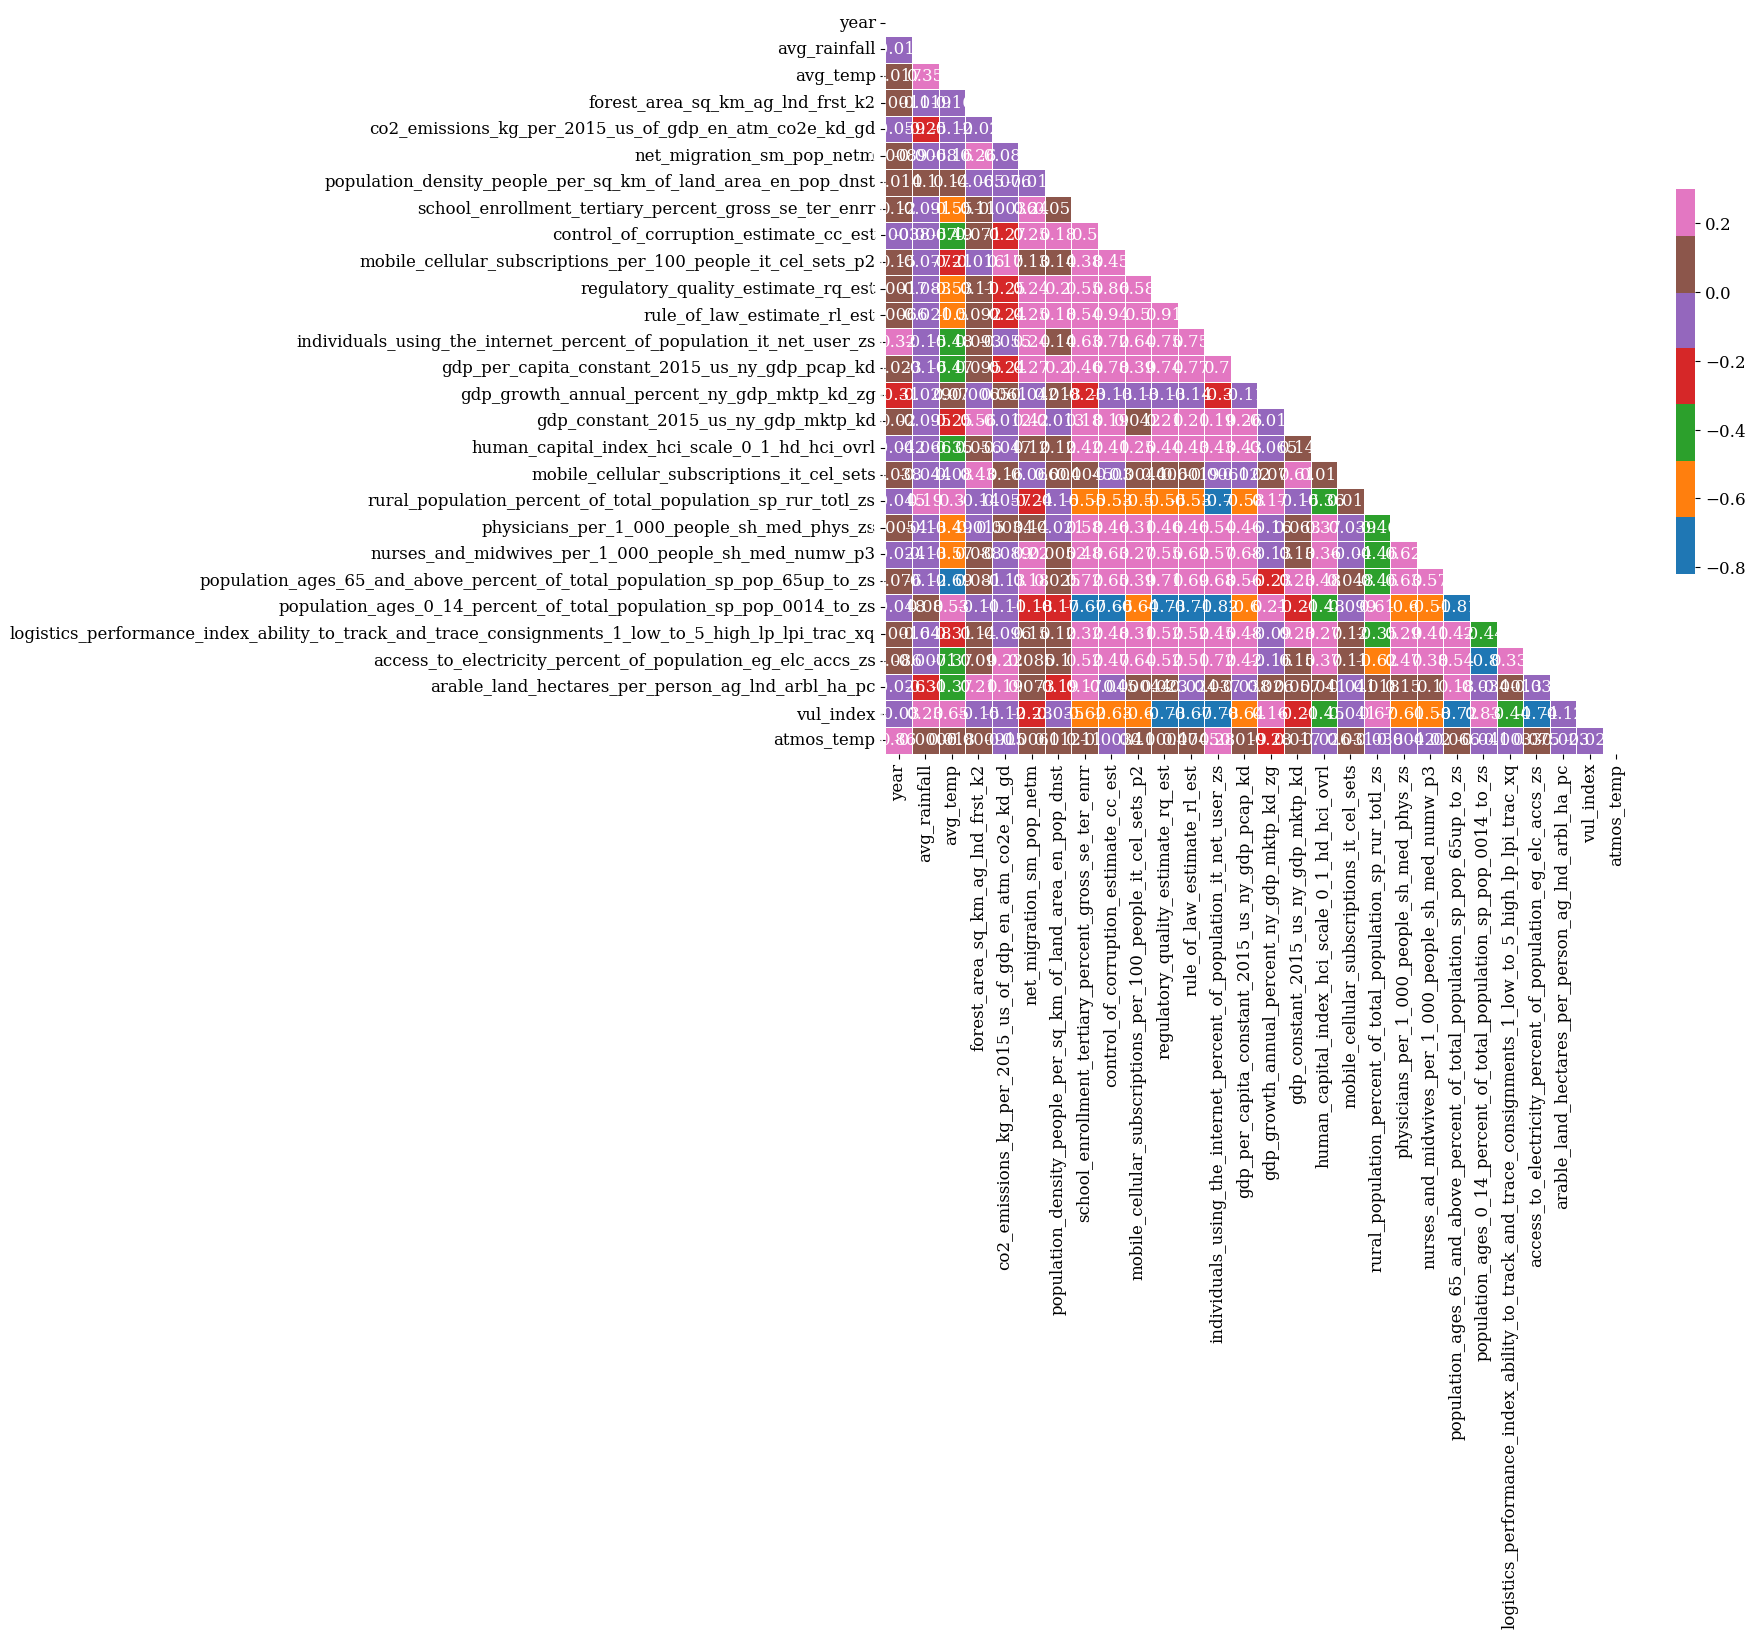

In [21]:
correlation_data = df_data.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data,dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (12,10))

# Generate a custom diverging colormap
#cmap =sns.palettes="vlag"
cmap =sns.color_palette("tab10")
#cmap=plt.cm.Reds

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data,mask=mask,  annot=True, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":.5})

#sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5});

#plt.savefig('./figures/correlation.eps')


### Feature Engineering

In [22]:
from sklearn.preprocessing import OneHotEncoder


In [23]:
##Encoding categorical variables
df_data_dummy = pd.get_dummies(df_data,columns=['country'],
                               prefix=['country'])
df_data_dummy.head()

,year,avg_rainfall,avg_temp,forest_area_sq_km_ag_lnd_frst_k2,co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd,net_migration_sm_pop_netm,population_density_people_per_sq_km_of_land_area_en_pop_dnst,school_enrollment_tertiary_percent_gross_se_ter_enrr,control_of_corruption_estimate_cc_est,mobile_cellular_subscriptions_per_100_people_it_cel_sets_p2,...,country_Uganda,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Zambia,country_Zimbabwe
0,2010,23.483333,14.175000,12084.4,0.534410,-141355,43.220447,41.484261,-1.645391,36.239655,...,0,0,0,0,0,0,0,0,0,0
1,2010,112.025000,12.208333,7820.7,0.459242,-29330,106.314635,45.002579,-0.531617,92.413400,...,0,0,0,0,0,0,0,0,0,0
2,2010,7.700000,23.708333,19180.0,0.809914,-33071,15.054684,30.977650,-0.552147,91.420824,...,0,0,0,0,0,0,0,0,0,0
3,2010,240.083333,26.958333,87.8,0.378311,295,194.761364,16.602810,1.301773,196.009102,...,0,0,0,0,0,0,0,0,0,0
4,2010,102.458333,6.358333,38632.0,0.193048,22786,101.350024,75.040253,1.596122,146.373912,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# shape and size of the dumming variables
print(df_data_dummy.shape)
print(df_data_dummy.size)

(1639, 177)
290103


In [25]:
miss =df_data_dummy.isna().sum()
print(miss)

year                                                     0
avg_rainfall                                             0
avg_temp                                                 0
forest_area_sq_km_ag_lnd_frst_k2                         0
co2_emissions_kg_per_2015_us_of_gdp_en_atm_co2e_kd_gd    0
                                                        ..
country_Uruguay                                          0
country_Uzbekistan                                       0
country_Vanuatu                                          0
country_Zambia                                           0
country_Zimbabwe                                         0
Length: 177, dtype: int64


In [27]:
### selecting the features
features = df_data_dummy.loc[:,df_data_dummy.columns != 'atmos_temp']
features = features.drop('year', axis=1)
features.shape

(1639, 175)

In [28]:
# # Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(12)

### A function to check our targeted variable to see if it is normally distributed

In [29]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

def check_normality(df, cname, return_log_transform=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, 
                                        figsize=(12,12),
                                        dpi = 80)
    
    
    # <<< 1ST Plot >>> 
    sns.distplot(df[cname] , 
                  fit=norm,
                  hist_kws=dict(edgecolor="black", 
                                    linewidth=2,
                                   color='blue'), 
                  kde_kws={'linestyle':'--', 
                           'linewidth':2,
                          "color": "darkgreen", 
                           "label": "KDE"},
                        ax=ax1)
    ax1.grid(True, linestyle='--')

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[cname])
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    ax1.legend(['Normal dist. ($\mu=$ {:.2f}; $\sigma=$ {:.2f})'.format(mu, sigma)],
                loc='best')
    # ax1.set_ylabel('Frequency')
    ax1.set_title('{} distribution'.format(cname))
   

    # <<< 2ND Plot >>> 
    #Get QQ-plot
    res = stats.probplot(np.unique(df[cname].values),
                         plot=ax2, 
                         rvalue=True)
    ax2.grid(True, linestyle='--')
    
    #print('yes')

    ## Log-transformation of the target variable
    #We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#     df[cname] = np.log1p(df[cname])

    #Check the new distribution 
    sns.distplot(np.log1p(df[cname]),
                 fit=norm,
                 hist_kws=dict(edgecolor="black", 
                                    linewidth=2,
                                   color='blue'), 
                  kde_kws={'linestyle':'--', 
                           'linewidth':2,
                          "color": "darkgreen", 
                           "label": "KDE"},
                        ax=ax3)
    ax3.grid(True, linestyle='--')

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(np.log1p(df[cname]))
    # print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    ax3.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    # plt.ylabel('Frequency')
    ax3.set_title('{} distribution in log scale'.format(cname))

    #Get also the QQ-plot
    res = stats.probplot(np.unique(np.log1p(df[cname]).values), plot=ax4,
                    rvalue=True)
    
    fig.tight_layout()
    #fig.savefig('./Fig2/dist.eps')
    #fig.savefig('./Fig2/dist.jpeg')
    
    if return_log_transform is True:
        return np.log1p(df[cname])

C:\Users\BOSU ABRAHAM\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\BOSU ABRAHAM\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


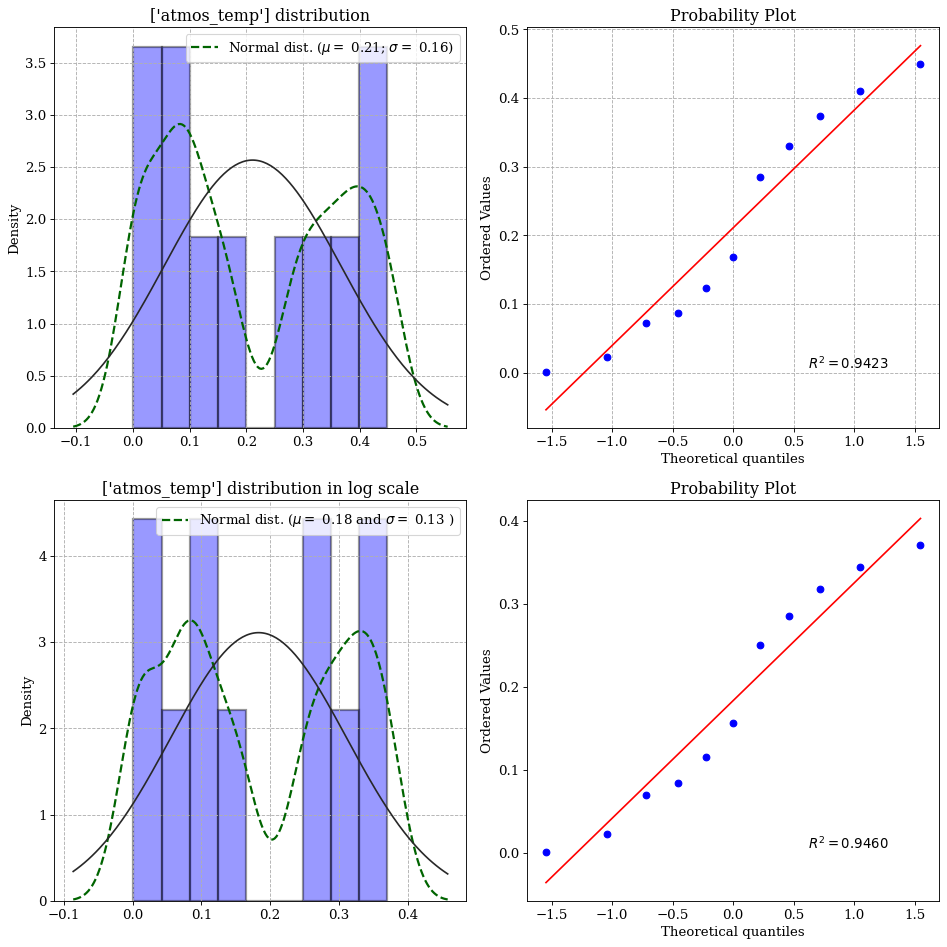

In [30]:
### Checking for the normality of the targeted variable
df_data['atmos_temp_log']=check_normality(df=df_data, cname=["atmos_temp"], return_log_transform=True)



### Scaling Features

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
### Normalizing the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

features.shape

(1639, 175)

###  Data Splitting into training and testing

In [33]:
### The target variable
label = df_data['atmos_temp']

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train_X, test_X, train_Y, test_Y= train_test_split(features, label,test_size=0.3,
                                                   random_state=42)
print('shape of train data:', train_X.shape)
print('shape of test data:', test_X.shape)
print('shape of train label:', train_Y.shape)
print('shape of test label:', test_Y.shape)

shape of train data: (1147, 175)
shape of test data: (492, 175)
shape of train label: (1147,)
shape of test label: (492,)


## Model Comparison & Selection

In [36]:

from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

In [37]:
### r2 is r2_score
def compare_models(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    r2 = r2_score(test_Y,y_pred)
    return([model_name, r2])

### rmse is the root mean square error
def compare_models1(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mse = mean_squared_error(test_Y, y_pred)
    return([model_name, mse])



###### mae represent mean absolute error
def compare_models2(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mae = mean_absolute_error(test_Y,y_pred)
    return([model_name, mae])


#3## MAPE
def compare_models3(model):
    model_name = model.__class__.__name__
    fit = model.fit(train_X,train_Y)
    y_pred = fit.predict(test_X)
    mape = mean_absolute_percentage_error(test_Y,y_pred)
    return([model_name, mape])

In [38]:
models = [
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    SVR(),
    LGBMRegressor(),
    XGBRegressor()
]

In [39]:
model_train  = list(map(compare_models,models))
model_train1 = list(map(compare_models1, models))
model_train2 = list(map(compare_models2, models))
model_train3 = list(map(compare_models3, models))
print("Model_train check R2_Score:",*model_train, sep="\n")
print()
print("Model_train1 check RMSE:", *model_train1, sep="\n")
print()
print("Model_train2 check MAE:", *model_train2,sep="\n")
print("Model_train3 check MAPE:", *model_train3,sep="\n")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6607
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 26
[LightGBM] [Info] Start training from score 0.213832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6607
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 26
[LightGBM] [Info] Start training from score 0.213832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6607
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 26
[LightGBM] [Info] Start traini

In [40]:
## we check the time it takes each model to run
import time

In [41]:
import time
### Random Forest 
rf = RandomForestRegressor()

start_time = time.time()

#rf_reg_tuned.fit(test_X, train_Y)
model_rf = rf.fit(train_X,train_Y)

print("RF--- %s seconds ---" % (time.time() - start_time))

### Gradient Boosting
gbm = GradientBoostingRegressor()
start_time = time.time()

#gbm_reg_tuned.fit(test_X, train_Y)
model_gbm = gbm.fit(train_X,train_Y)

print("GBM--- %s seconds ---" % (time.time() - start_time))

### Light Gradient Bossting
lgbm = LGBMRegressor()
start_time = time.time()

#lgbm_reg_tuned.fit(test_X, train_Y)
model_lgbm = lgbm.fit(train_X,train_Y)

print("LGBM--- %s seconds ---" % (time.time() - start_time))

### Extreme Gradient Boosting
xgbm = XGBRegressor()
#xgbm_reg_tuned.fit(test_X, train_Y)
model_xgbm = xgbm.fit(train_X,train_Y)

print("XGBM--- %s seconds ---" % (time.time() - start_time))



###################
svm1= SVR()
start_time = time.time()

#rf_reg_tuned.fit(test_X, train_Y)
model_svm = svm1.fit(train_X,train_Y)

print("SVM--- %s seconds ---" % (time.time() - start_time))




RF--- 3.7070934772491455 seconds ---
GBM--- 2.0393218994140625 seconds ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6607
[LightGBM] [Info] Number of data points in the train set: 1147, number of used features: 26
[LightGBM] [Info] Start training from score 0.213832
LGBM--- 0.29363250732421875 seconds ---
XGBM--- 1.1544785499572754 seconds ---
SVM--- 0.1698596477508545 seconds ---


## Line Curve

In [42]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [43]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

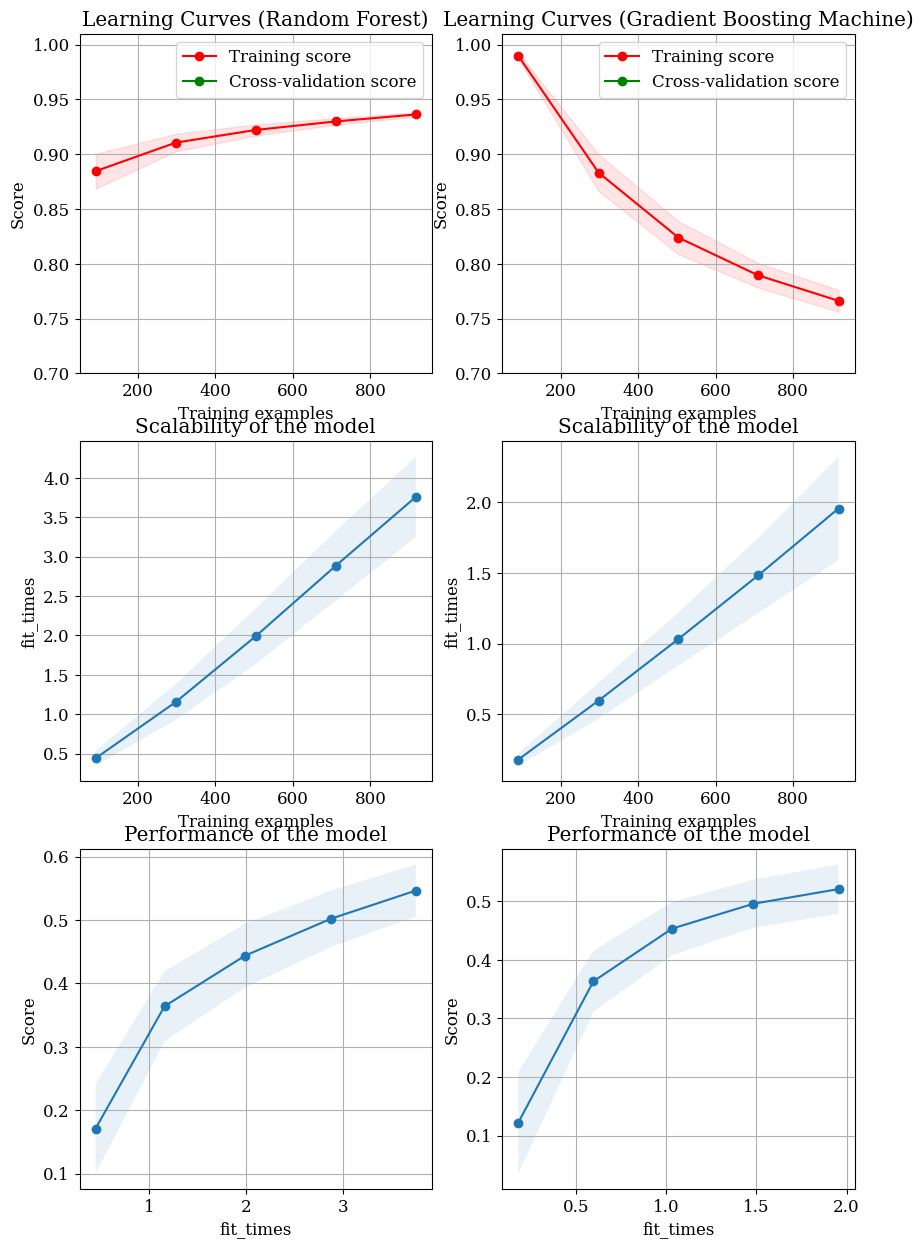

In [44]:
### Learning curves of RF and GBM

fig, axes = plt.subplots(3, 2, figsize=(10, 15))



title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (Gradient Boosting Machine)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                                      #random_state=1, subsample=0.75)
estimator =GradientBoostingRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

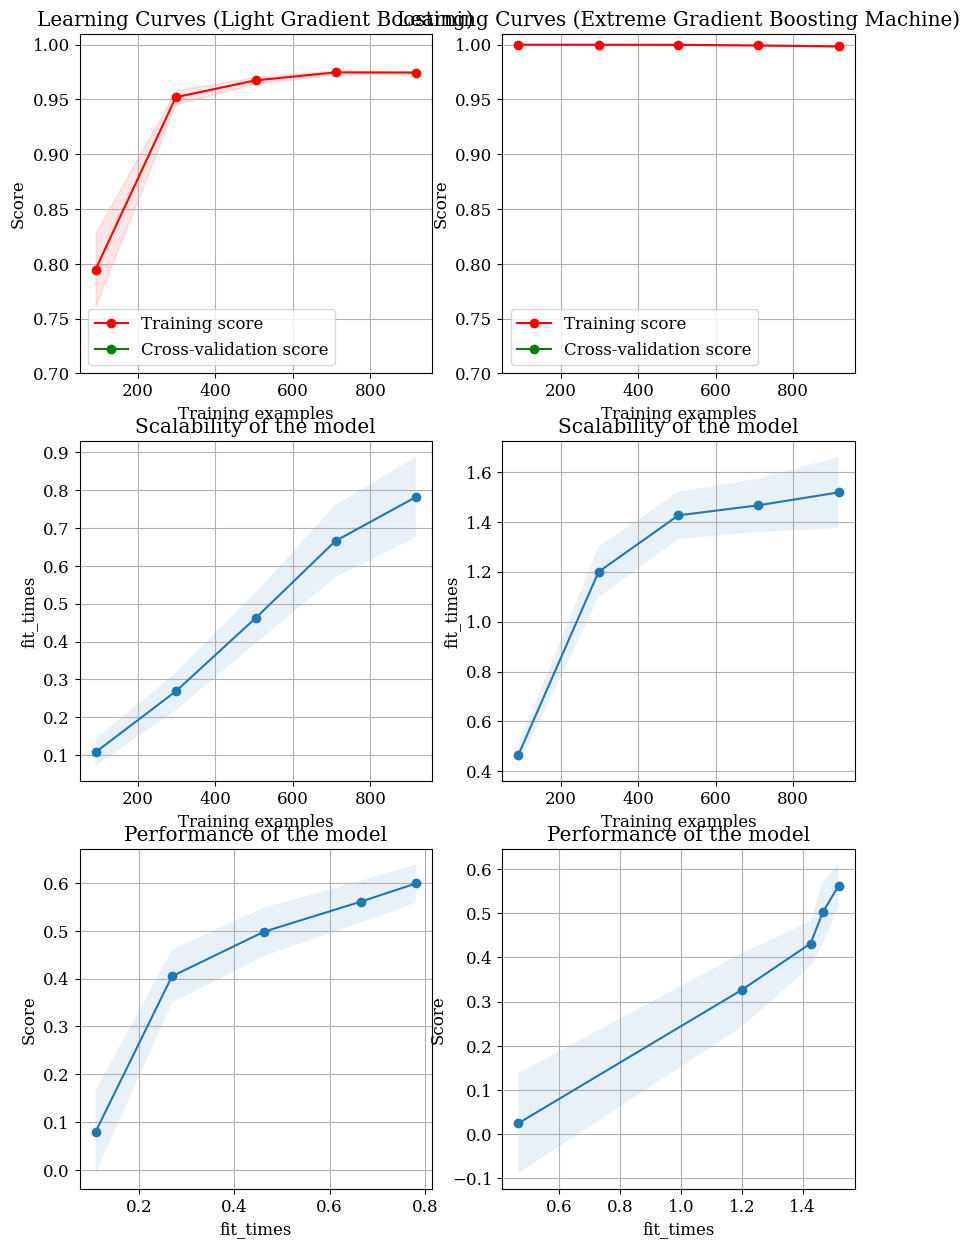

In [45]:
### Learning curves of LGBM and XGBM

fig, axes = plt.subplots(3, 2, figsize=(10, 15))



title = "Learning Curves (Light Gradient Boosting)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LGBMRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (Extreme Gradient Boosting Machine)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                                      #random_state=1, subsample=0.75)
estimator =XGBRegressor()
plot_learning_curve(
    estimator, title, train_X, train_Y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [48]:
#####

test_df = pd.DataFrame(test_X,
                       columns=df_data_dummy.loc[:,df_data_dummy.columns !='atmos_temp'].columns)

ValueError: Shape of passed values is (492, 175), indices imply (492, 176)

In [ ]:
test_df

In [49]:
rclf = RandomForestRegressor()
rf_model = rclf.fit(train_X,train_Y)
test_df1 = test_df
test_df1["atmos_temp_predicted"] = rf_model.predict(test_X)
test_df1["atmos_temp_actual"] = pd.DataFrame(test_Y)["atmos_temp"].tolist()
residuals_rf = test_df1["atmos_temp_actual"] - test_df1["atmos_temp_predicted"]
r21 = r2_score(test_df1["atmos_temp_actual"],test_df1["atmos_temp_predicted"])
r21

NameError: name 'test_df' is not defined

In [ ]:
itm = test_df[[col for col in test_df.columns if 'country' in col]].stack()[
    test_df[[col for col in test_df.columns if 'country' in col]].stack()>0]

#itm = test_df[[col for col in test_df.columns if 'Item' in col]].stack()[test_df[[col for col in test_df.columns if 'Item' in col]].stack()>0]

itmlist =list(pd.DataFrame(itm).index.get_level_values(1))

items = [i.split("_")[1] for i in itmlist]

test_df.head()

In [ ]:
varimp_rf = {'Relative Importance':rf_model.feature_importances_,
          'Features':df_data_dummy.columns[df_data_dummy.columns != "vul_index"]}

NameError: name 'varimp_rf' is not defined

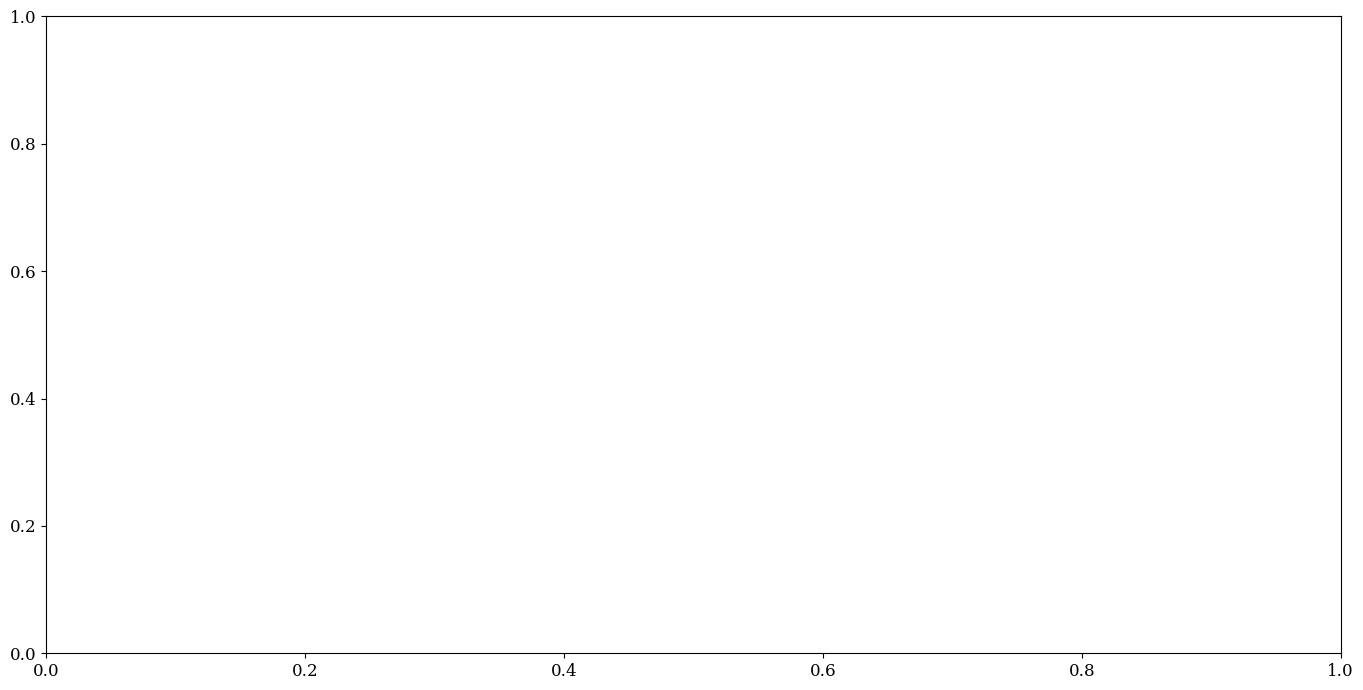

In [50]:
#a4_dims = (8.27,16.7)
a4_dims = (16.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp_rf)
df.sort_values(ascending=False,by=["Relative Importance"],inplace=True)
df=df.dropna()

sns.barplot(x="Relative Importance",y="Features",palette="vlag",data=df,orient="h",ax=ax);


In [ ]:
final_rf = best_rf.fit(train_X,train_Y)
final_gbm = best_gbm.fit(train_X,train_Y)
final_svm = best_svm.fit(train_X,train_Y)

In [ ]:

df = df_yield_dummy.drop(columns=['Year', 'Country'])

### Feature  Importance

In [ ]:
rclf = RandomForestRegressor()
#rclf = best_rf
#rclf = best_c
rf_model = rclf.fit(train_X,train_Y)
test_df1 = test_df
test_df1["yield_predicted"] = rf_model.predict(test_X)
test_df1["yield_actual"] = pd.DataFrame(test_Y)["Yield_log"].tolist()
residuals_rf = test_df1["yield_actual"] - test_df1["yield_predicted"]
r21 = r2_score(test_df1["yield_actual"],test_df1["yield_predicted"])
test_group = test_df1.groupby("Crop")
test_group.apply(lambda x : r2_score(x.yield_actual, x.yield_predicted))
r21

In [ ]:
varimp_rf = {'Relative Importance':rf_model.feature_importances_,
          'Features':df_data_dummy.columns[df_data_dummy.columns != "vul_index"]}